<a href="https://colab.research.google.com/github/sukant16/EIP-Submissions/blob/master/Asignment1_P2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install image-classifiers

     |████████████████████████████████| 81kB 3.2MB/s 


In [0]:
%matplotlib inline 

from __future__ import print_function

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

import keras
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input
from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K

from classification_models.resnet import ResNet18, preprocess_input

import os

import cv2
import sys
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
batch_size = 32
num_classes = 10
steps_per_epoch = x_train.shape[0]//batch_size
epochs = 30
data_augmentation = True
os.chdir('/content/gdrive/My Drive/Colab Notebooks')

In [7]:
subtract_pixel_mean = True
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [8]:
x_train, x_test = preprocess_input(x_train), preprocess_input(x_test)
input_shape

(32, 32, 3)

In [0]:
base_model = ResNet18(input_shape=input_shape, weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])

for layer in base_model.layers:
  layer.trainable = True

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [0]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
save_dir = os.path.join(os.getcwd(), 'assgn5_saved_models')
model_name = 'cifar10_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True, period=4)

# def lr_schedule(epoch):
#     """Learning Rate Schedule

#     Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
#     Called automatically every epoch as part of callbacks during training.

#     # Arguments
#         epoch (int): The number of epochs

#     # Returns
#         lr (float32): learning rate
#     """
#     lr = 1e-3
#     if epoch > 180:
#         lr *= 0.5e-3
#     elif epoch > 160:
#         lr *= 1e-3
#     elif epoch > 120:
#         lr *= 1e-2
#     elif epoch > 80:
#         lr *= 1e-1
#     print('Learning rate: ', lr)
#     return lr
  
  
  
# lr_scheduler = LearningRateScheduler(lr_schedule)

# lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)

callbacks = [checkpoint] #, lr_reducer, lr_scheduler]



In [0]:
data_augmentation = True
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test), 
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Epoch 1/30
1562/1562 [==============================] - 126s 81ms/step - loss: 1.1076 - acc: 0.6134 - val_loss: 0.7589 - val_acc: 0.7364
Epoch 2/30
1562/1562 [==============================] - 122s 78ms/step - loss: 0.7713 - acc: 0.7311 - val_loss: 0.6765 - val_acc: 0.7656
Epoch 3/30
1562/1562 [==============================] - 123s 78ms/step - loss: 0.6776 - acc: 0.7639 - val_loss: 0.6069 - val_acc: 0.7893
Epoch 4/30
1562/1562 [==============================] - 122s 78ms/step - loss: 0.6082 - acc: 0.7894 - val_loss: 0.5696 - val_acc: 0.8033

Epoch 00004: val_acc improved from -inf to 0.80330, saving model to /content/gdrive/My Drive/Colab Notebooks/assgn5_saved_models/cifar10_model.004.h5
Epoch 5/30
1562/1562 [==============================] - 122s 78ms/step - loss: 0.5596 - acc: 0.8062 - val_loss: 0.5317 - val_acc: 0.8170
Epoch 6/30
1562/1562 [==============================] - 122s 78ms/step - loss: 0.5277 - acc: 0.8147 - val_loss: 0.5123 - val_acc:

In [0]:
model_name ='cifar_epoch_30_weights.h5'
filepath = os.path.join(save_dir, model_name)
model.save(filepath)

In [0]:
# decreasing the learning rate to 0.5e-3
sgd = SGD(lr=0.5e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_test, y_test), 
                    steps_per_epoch=steps_per_epoch,
                    epochs=20, verbose=1, workers=4,
                    callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Epoch 1/20
1562/1562 [==============================] - 130s 83ms/step - loss: 0.1871 - acc: 0.9330 - val_loss: 0.4450 - val_acc: 0.8643
Epoch 2/20
1562/1562 [==============================] - 125s 80ms/step - loss: 0.1760 - acc: 0.9376 - val_loss: 0.4283 - val_acc: 0.8700

Epoch 00002: val_acc improved from 0.86020 to 0.87000, saving model to /content/gdrive/My Drive/Colab Notebooks/assgn5_saved_models/cifar10_model.002.h5
Epoch 3/20
1562/1562 [==============================] - 126s 80ms/step - loss: 0.1665 - acc: 0.9419 - val_loss: 0.4381 - val_acc: 0.8694
Epoch 4/20
1562/1562 [==============================] - 126s 80ms/step - loss: 0.1664 - acc: 0.9416 - val_loss: 0.4414 - val_acc: 0.8667
Epoch 5/20
1562/1562 [==============================] - 123s 78ms/step - loss: 0.1610 - acc: 0.9440 - val_loss: 0.4475 - val_acc: 0.8676
Epoch 6/20
1562/1562 [==============================] - 122s 78ms/step - loss: 0.1608 - acc: 0.9431 - val_loss: 0.4556 - val_acc: 0.8643

Epoch 00006: val_acc di

In [0]:
model_name ='cifar_epoch_50_weights.h5'
filepath = os.path.join(save_dir, model_name)
model.save(filepath)

In [0]:
from keras.models import load_model
filepath = os.path.join(os.getcwd(), "assgn5_saved_models/cifar_epoch_50_weights.h5")
model = load_model(filepath)

In [0]:
preds = model.predict(x_test)

In [50]:
pred_classes = np.argmax(preds, axis=1)
pred_classes.shape

(10000,)

In [51]:
actual_classes = np.argmax(y_test, axis=1)
actual_classes.shape

(10000,)

In [0]:
predicton_comparison = pred_classes==actual_classes

In [53]:
misclassified_ids = [i for i,x in enumerate(predicton_comparison) if not x]
misclassified_ids[:5]

[6, 9, 35, 36, 47]

In [0]:
last_conv_layer = model.get_layer("stage4_unit2_conv2")


In [0]:
(x_img_train, y_img_train), (x_img_test, y_img_test) = cifar10.load_data()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


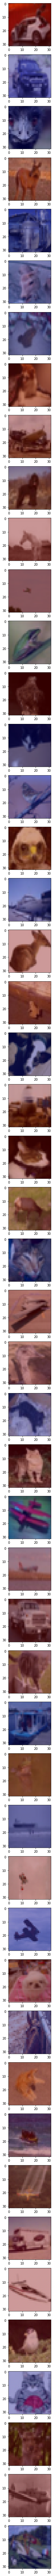

In [0]:
num = 1
fig = plt.figure(figsize= (4, 150) )
for id in misclassified_ids:
  class_id = pred_classes[id]
  class_output = model.output[:, class_id]
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  x = np.expand_dims(x_test[id,:], axis=0)
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  img = x_img_test[id,:]
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
  plt.subplot(50,1, num)
  plt.imshow(img)
  plt.imshow(superimposed_img)
  cv2.waitKey(0)
  
  num += 1
  if num > 50:
    break